In [133]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

data = input_data.read_data_sets("./mnist/", one_hot=True)

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [8]:
# Print shapes of data
print("Training X: ", data.train.images.shape)
print("Training Y: ", data.train.labels.shape)
print("Test X: ", data.test.images.shape)
print("Test Y: ", data.test.labels.shape)

Training X:  (55000, 784)
Training Y:  (55000, 10)
Test X:  (10000, 784)
Test Y:  (10000, 10)


In [159]:
def gaussian_additive_noise(x, std):
    
    return x + tf.random_normal(shape=tf.shape(x), dtype=tf.float32, mean=0.0, stddev=std)

In [162]:
imgs = tf.placeholder(tf.float32, shape=[None, 28*28], name="Input")

noise = gaussian_additive_noise(imgs, 0.1)
corrupted_imgs_test = noise.eval(session=tf.Session(), feed_dict={imgs: data.test.images})

In [128]:
def plot_mnist(imgs, lbls):
    
    classes = np.argmax(lbls, 1)

    for i in range(10):
        ids = (classes == i)
        
        images = imgs[ids][0:10]
            
        for j in range(3):   
            plt.subplot(5, 10, i + j*10 + 1)
            plt.imshow(images[j].reshape(28, 28), cmap='gray')

            if j == 0:
                plt.title(i)
                
            plt.axis('off')
    plt.show()

In [141]:
def autoencoder(dims=[28*28, 512, 256, 128, 64, 32], std=0.01):
    
    x = tf.placeholder(tf.float32, shape=[None, dims[0]], name="Input")

    cur = gaussian_additive_noise(x, 0.1)
    
    Ws = []
    bs = []
    
    # encoder
    for i, n_out in enumerate(dims[1:]):
        n_inp = int(cur.get_shape()[1])
        
        W = tf.Variable(tf.random_normal(shape=[n_inp, n_out], mean=0.0, stddev=std, dtype=tf.float32))
        b = tf.Variable(tf.random_normal(shape=[n_out], mean=0.0, stddev=std, dtype=tf.float32))
        
        Ws.append(W)
        bs.append(b)
        
        out = tf.nn.tanh(cur @ W + b)
        cur = out
        
    z = cur
    Ws.reverse()
    bs.reverse()
    
    # decoder
    for i, n_out in enumerate(dims[:-1][::-1]):
        
        W = tf.transpose(Ws[i])
        b = tf.Variable(tf.random_normal(shape=[n_out], mean=0.0, stddev=std, dtype=tf.float32))
        
        
        out = tf.nn.tanh(cur @ W + b)
        cur = out
    
    y = cur
    
    loss = tf.reduce_mean(tf.square(y - x))
    
    return (x, z, y, loss)

In [155]:
lr = 0.001
batch_size = 64
n_epochs = 50
n_batchs = data.train.num_examples // batch_size

x, z, y, loss = autoencoder(dims=[28*28, 512, 256, 64], std=0.01)
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)


S = tf.Session()
S.run(tf.global_variables_initializer())


for i_epoch in range(1, n_epochs+1):
    loss_avg = 0.0
    for i_batch in range(1, n_batchs+1):
        b, _ = data.train.next_batch(batch_size)
        _, loss_val = S.run([optimizer, loss], feed_dict={x: b})
        loss_avg = (loss_val / batch_size)
    print(i_epoch, loss_avg)
    loss_avg = 0.0

1 33.380035400390625
2 21.62017822265625
3 19.464731216430664
4 16.385299682617188
5 14.959287643432617
6 12.546995162963867
7 13.526947021484375
8 11.978080749511719
9 11.416245460510254
10 10.357454299926758
11 10.248832702636719
12 9.510416984558105
13 9.242302894592285
14 9.36292839050293
15 8.316205978393555
16 8.980324745178223
17 9.698214530944824
18 9.203201293945312
19 9.107975006103516
20 9.140499114990234
21 8.551971435546875
22 7.853026390075684
23 8.338578224182129
24 8.958144187927246
25 7.931173801422119
26 9.10947322845459
27 8.124393463134766
28 9.25344467163086
29 7.957667350769043
30 8.225481986999512
31 7.931500434875488
32 7.77481746673584
33 7.993954658508301
34 8.259342193603516
35 8.165870666503906
36 7.839664459228516
37 7.265006065368652
38 6.472005844116211
39 7.68241024017334
40 7.862390041351318
41 8.809000015258789
42 7.799749851226807
43 7.053318023681641
44 7.4205641746521
45 7.182109832763672
46 7.259000778198242
47 7.355192184448242
48 7.00942707061767

		 Original Images


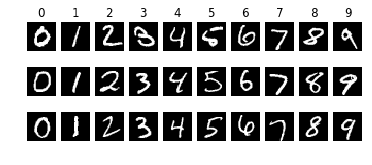

		 Corrupted Images


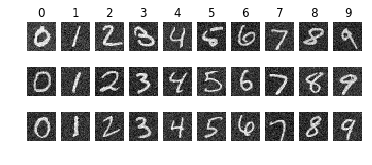

		 Reconstructed Images


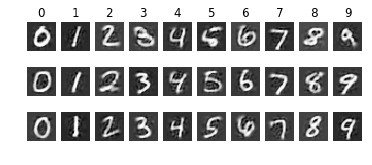

In [164]:
n_samples = 10
reconstructed = S.run([y], feed_dict={x: corrupted_imgs_test})

reconstructed = reconstructed[0]

print("\t\t Original Images")
plot_mnist(data.test.images, data.test.labels)
print("\t\t Corrupted Images")
plot_mnist(corrupted_imgs_test, data.test.labels)
print("\t\t Reconstructed Images")
plot_mnist(reconstructed, data.test.labels)